In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings

In [2]:
class SistemaSolarML:

    EFICIENCIA_PAINEIS = 0.20  # 20% eficiência média
    HORAS_SOL_DIA = 5.5  # Média brasileira
    CUSTO_POR_WATT = 5.50  # R$ por Watt instalado
    TARIFA_ENERGIA = 0.85  # R$ por kWh
    FATOR_EMISSAO_CO2 = 0.0817  # kg CO2 por kWh
    AREA_POR_KWP = 7  # m² necessários por kWp
    PERDAS_SISTEMA = 0.15  # 15% de perdas (cabos, inversores, temperatura)

    def __init__(self, random_state=42):
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.model = None
        self.df = None

    def gerar_dados_realisticos(self, n_samples=1000):

        np.random.seed(self.random_state)

        consumo_mensal = np.random.lognormal(5.5, 0.8, n_samples)
        consumo_mensal = np.clip(consumo_mensal, 100, 3000)

        area_base = consumo_mensal * 0.08
        area_disponivel = area_base + np.random.normal(0, 25, n_samples)
        area_disponivel = np.clip(area_disponivel, 5, 200)

        irradiacao_local = np.random.normal(5.0, 1.2, n_samples)
        irradiacao_local = np.clip(irradiacao_local, 3.5, 6.5)

        fator_performance = self.HORAS_SOL_DIA * self.EFICIENCIA_PAINEIS * (1 - self.PERDAS_SISTEMA)
        tamanho_sistema = consumo_mensal / (30 * fator_performance * irradiacao_local / 5.5)

        tamanho_sistema *= np.random.normal(1.0, 0.1, n_samples)
        tamanho_sistema = np.clip(tamanho_sistema, 0.5, 50)

        tamanho_max_area = area_disponivel / self.AREA_POR_KWP
        tamanho_sistema = np.minimum(tamanho_sistema, tamanho_max_area)

        self.df = pd.DataFrame({
            'consumo_mensal': consumo_mensal,
            'area_disponivel': area_disponivel,
            'irradiacao_local': irradiacao_local,
            'tamanho_sistema_kWp': tamanho_sistema
        })

        return self.df

    def treinar_modelo(self, model_type='random_forest'):

        if self.df is None:
            raise ValueError("Gere os dados primeiro usando gerar_dados_realisticos()")

        X = self.df[['consumo_mensal', 'area_disponivel', 'irradiacao_local']]
        y = self.df['tamanho_sistema_kWp']

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=self.random_state
        )

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        if model_type == 'linear':
            self.model = LinearRegression()
        else:
            self.model = RandomForestRegressor(
                n_estimators=100,
                max_depth=15,
                min_samples_split=5,
                random_state=self.random_state,
                n_jobs=-1
            )

        self.model.fit(X_train_scaled, y_train)

        y_pred = self.model.predict(X_test_scaled)

        metrics = {
            'r2': r2_score(y_test, y_pred),
            'mae': mean_absolute_error(y_test, y_pred),
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred))
        }

        cv_scores = cross_val_score(
            self.model, X_train_scaled, y_train, cv=5, scoring='r2'
        )
        metrics['cv_r2_mean'] = cv_scores.mean()
        metrics['cv_r2_std'] = cv_scores.std()

        return metrics, y_test, y_pred

    def plotar_resultados(self, y_test, y_pred):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='black')
        plt.plot([y_test.min(), y_test.max()],
                 [y_test.min(), y_test.max()],
                 '--r', linewidth=2, label='Predição Perfeita')
        plt.xlabel('Tamanho Real (kWp)', fontsize=12)
        plt.ylabel('Tamanho Previsto (kWp)', fontsize=12)
        plt.title('Predição vs Realidade', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        erros = y_test - y_pred
        plt.hist(erros, bins=30, edgecolor='black', alpha=0.7)
        plt.xlabel('Erro (kWp)', fontsize=12)
        plt.ylabel('Frequência', fontsize=12)
        plt.title('Distribuição dos Erros', fontsize=14, fontweight='bold')
        plt.axvline(0, color='r', linestyle='--', linewidth=2, label='Erro Zero')
        plt.legend()
        plt.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.show()

    def validar_entrada(self, consumo_mensal, area_disponivel, irradiacao_local):
        if consumo_mensal <= 0:
            raise ValueError("Consumo mensal deve ser positivo")
        if area_disponivel <= 0:
            raise ValueError("Área disponível deve ser positiva")
        if not 3.0 <= irradiacao_local <= 7.0:
            raise ValueError("Irradiação deve estar entre 3.0 e 7.0 kWh/m²/dia")
        if consumo_mensal > 10000:
            print("⚠️ Consumo muito alto, considere sistema comercial/industrial")

    def calcular_sistema(self, consumo_mensal, area_disponivel, irradiacao_local):

        self.validar_entrada(consumo_mensal, area_disponivel, irradiacao_local)

        if self.model is None:
            raise ValueError("Treine o modelo primeiro usando treinar_modelo()")

        entrada = np.array([[consumo_mensal, area_disponivel, irradiacao_local]])
        entrada_scaled = self.scaler.transform(entrada)
        tamanho_kwp = self.model.predict(entrada_scaled)[0]

        area_necessaria = tamanho_kwp * self.AREA_POR_KWP
        if area_necessaria > area_disponivel:
            tamanho_kwp = area_disponivel / self.AREA_POR_KWP
            area_necessaria = area_disponivel
            print(f"⚠️ Sistema ajustado para {tamanho_kwp:.2f} kWp devido à área limitada")

        geracao_diaria = (tamanho_kwp * irradiacao_local *
                         self.EFICIENCIA_PAINEIS * (1 - self.PERDAS_SISTEMA))
        geracao_mensal = geracao_diaria * 30
        geracao_anual = geracao_diaria * 365

        economia_mensal = min(geracao_mensal, consumo_mensal) * self.TARIFA_ENERGIA
        economia_anual = economia_mensal * 12

        custo_instalacao = tamanho_kwp * 1000 * self.CUSTO_POR_WATT
        payback = custo_instalacao / economia_anual if economia_anual > 0 else float('inf')

        reducao_co2_anual = geracao_anual * self.FATOR_EMISSAO_CO2


        return {
            'tamanho_kwp': tamanho_kwp,
            'area_necessaria': area_necessaria,
            'geracao_diaria': geracao_diaria,
            'geracao_mensal': geracao_mensal,
            'geracao_anual': geracao_anual,
            'economia_mensal': economia_mensal,
            'economia_anual': economia_anual,
            'custo_instalacao': custo_instalacao,
            'payback_anos': payback,
            'percentual_cobertura': (geracao_mensal / consumo_mensal) * 100
        }

    def relatorio_completo(self, resultado):
        """Gera relatório formatado dos resultados"""
        print("\n" + "="*60)
        print("           RELATÓRIO DE DIMENSIONAMENTO SOLAR")
        print("="*60)

        print("\nEspecificações Técnicas:")
        print(f"   • Potência do Sistema: {resultado['tamanho_kwp']:.2f} kWp")
        print(f"   • Área Necessária: {resultado['area_necessaria']:.2f} m²")
        print(f"   • Painéis Estimados: {int(resultado['tamanho_kwp'] * 3)} unidades (330W)")

        print("\nGeração De Energia:")
        print(f"   • Geração Diária: {resultado['geracao_diaria']:.2f} kWh/dia")
        print(f"   • Geração Mensal: {resultado['geracao_mensal']:.2f} kWh/mês")
        print(f"   • Geração Anual: {resultado['geracao_anual']:.2f} kWh/ano")
        print(f"   • Cobertura: {resultado['percentual_cobertura']:.1f}% do consumo")

        print("\nAnálise Financeira:")
        print(f"   • Investimento Inicial: R$ {resultado['custo_instalacao']:,.2f}")
        print(f"   • Economia Mensal: R$ {resultado['economia_mensal']:,.2f}")
        print(f"   • Economia Anual: R$ {resultado['economia_anual']:,.2f}")
        print(f"   • Payback: {resultado['payback_anos']:.1f} anos")

        print("\nImpcto Ambiental:")
        print(f"   • Redução CO₂/ano: {resultado['reducao_co2_anual']:.2f} kg")
        print(f"   • Equivalente a plantar ~{int(resultado['reducao_co2_anual']*25/20)} árvores")

        print("\n" + "="*60 + "\n")

1000 amostras geradas
   consumo_mensal  area_disponivel  irradiacao_local  tamanho_sistema_kWp
0      364.079162        64.110219          4.189786             9.158603
1      219.069397        40.641394          4.826578             5.805913
2      410.818220        34.356217          4.049096             4.908031
3      827.512229        50.027559          4.630446             7.146794
4      202.892707        33.686999          3.500000             4.812428
   • R² Score: 0.9955
   • MAE: 0.0793 kWp
   • RMSE: 0.2750 kWp
   • CV R² (médio): 0.9873 ± 0.0066


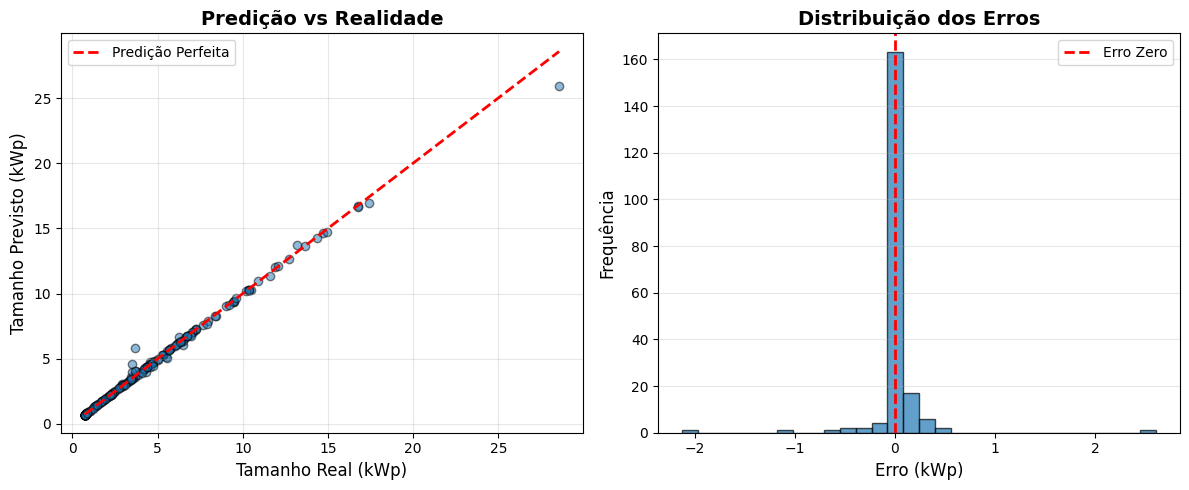


           EXEMPLO: RESIDÊNCIA TÍPICA

📝 DADOS DE ENTRADA:
   • Consumo Mensal: 500 kWh
   • Área Disponível: 50 m²
   • Irradiação Solar: 5.5 kWh/m²/dia
⚠️ Sistema ajustado para 7.14 kWp devido à área limitada

           RELATÓRIO DE DIMENSIONAMENTO SOLAR

Especificações Técnicas:
   • Potência do Sistema: 7.14 kWp
   • Área Necessária: 50.00 m²
   • Painéis Estimados: 21 unidades (330W)

Geração De Energia:
   • Geração Diária: 6.68 kWh/dia
   • Geração Mensal: 200.36 kWh/mês
   • Geração Anual: 2437.68 kWh/ano
   • Cobertura: 40.1% do consumo

Análise Financeira:
   • Investimento Inicial: R$ 39,285.71
   • Economia Mensal: R$ 170.30
   • Economia Anual: R$ 2,043.64
   • Payback: 19.2 anos

Impcto Ambiental:
   • Redução CO₂/ano: 199.16 kg
   • Equivalente a plantar ~248 árvores




/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [3]:
def main():
    sistema = SistemaSolarML(random_state=42)

    df = sistema.gerar_dados_realisticos(n_samples=1000)
    print(f"{len(df)} amostras geradas")
    print(df.head())

    metrics, y_test, y_pred = sistema.treinar_modelo(model_type='random_forest')

    print(f"   • R² Score: {metrics['r2']:.4f}")
    print(f"   • MAE: {metrics['mae']:.4f} kWp")
    print(f"   • RMSE: {metrics['rmse']:.4f} kWp")
    print(f"   • CV R² (médio): {metrics['cv_r2_mean']:.4f} ± {metrics['cv_r2_std']:.4f}")

    sistema.plotar_resultados(y_test, y_pred)

    print("\n" + "="*60)
    print("           EXEMPLO: RESIDÊNCIA TÍPICA")
    print("="*60)

    consumo = 500  # kWh/mês
    area = 50  # m²
    irradiacao = 5.5  # kWh/m²/dia

    print(f"\n📝 DADOS DE ENTRADA:")
    print(f"   • Consumo Mensal: {consumo} kWh")
    print(f"   • Área Disponível: {area} m²")
    print(f"   • Irradiação Solar: {irradiacao} kWh/m²/dia")

    resultado = sistema.calcular_sistema(consumo, area, irradiacao)
    resultado['reducao_co2_anual'] = resultado['geracao_anual'] * sistema.FATOR_EMISSAO_CO2
    sistema.relatorio_completo(resultado)

main()